## Draft for WB attack with LeNet on MNIST

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

##### MNIST dataset code setup for adversarial attack

In [58]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', 
                   train=False, 
                   download=True, 
                   transform=transforms.Compose([
                       transforms.ToTensor(), 
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])
    ),
    batch_size=1, shuffle=True)

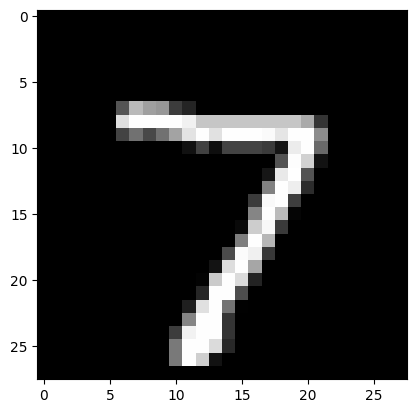

In [59]:
ex_img = test_loader.dataset[0][0].squeeze()

plt.imshow(ex_img, cmap='gray')

##### LeNet (pre-trained) model setup

In [60]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
model = LeNet().to(device)
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─Conv2d: 1-2                            [1, 64, 24, 24]           18,496
├─Dropout: 1-3                           [1, 64, 12, 12]           --
├─Linear: 1-4                            [1, 128]                  1,179,776
├─Dropout: 1-5                           [1, 128]                  --
├─Linear: 1-6                            [1, 10]                   1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 12.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.47
Params size (MB): 4.80
Estimated Total Size (MB): 5.27

In [61]:
path = r'lenet_mnist_model.pth'
model.load_state_dict(torch.load(path, map_location=device))

<All keys matched successfully>

In [62]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

##### Attack FSGM

In [63]:
epsilons = [0, .05, .1, .15, .2, .25, .3, .35]

In [64]:
# from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [65]:
# from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [66]:
# from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9912 / 10000 = 0.9912
Epsilon: 0.05	Test Accuracy = 9606 / 10000 = 0.9606
Epsilon: 0.1	Test Accuracy = 8740 / 10000 = 0.874
Epsilon: 0.15	Test Accuracy = 7107 / 10000 = 0.7107
Epsilon: 0.2	Test Accuracy = 4845 / 10000 = 0.4845
Epsilon: 0.25	Test Accuracy = 2701 / 10000 = 0.2701
Epsilon: 0.3	Test Accuracy = 1408 / 10000 = 0.1408
Epsilon: 0.35	Test Accuracy = 790 / 10000 = 0.079


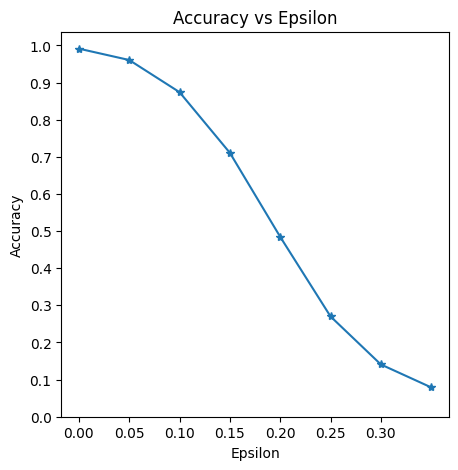

In [67]:
# from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

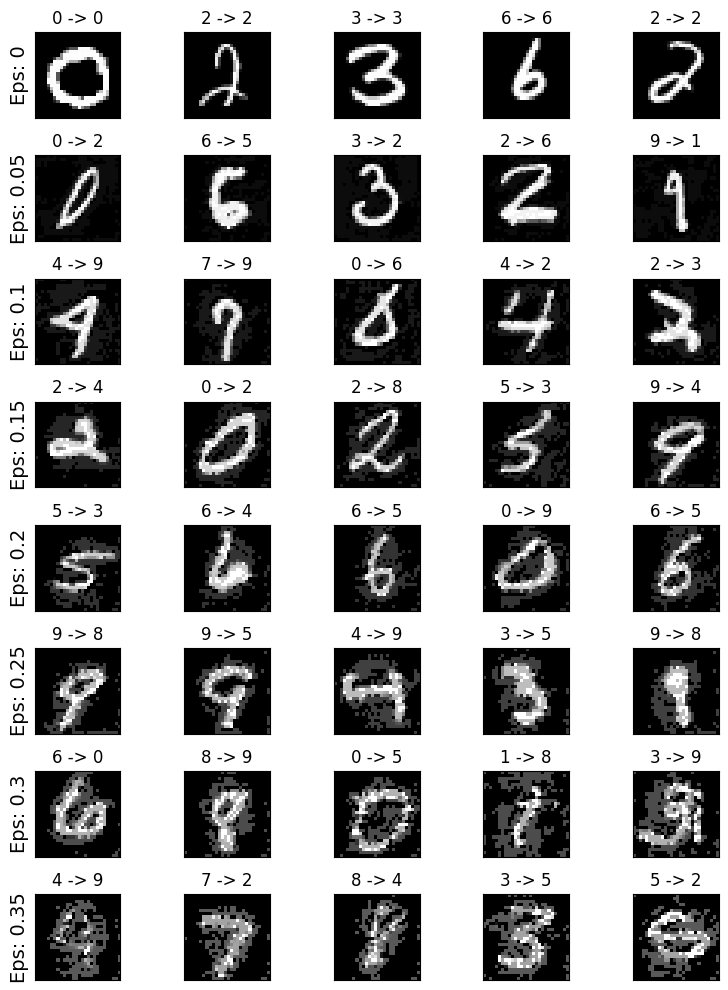

In [68]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

##### ProjGD attack code setup

In [ ]:
def project(x, epsilon, data):

    diff = x - data
    diff = torch.clamp(diff, -epsilon, epsilon)
    return data + diff

def proj_grad(model, data, target, epsilon, alpha, iters):

    x = data.clone().detach().requires_grad_(True)
    for i in range(iters):
        output = model(x)
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward() 
        if x.grad is None:
            data_grad = torch.zeros_like(x)
        else:
            data_grad = x.grad.data
        x = project(x + alpha * data_grad.sign(), epsilon, data)
        x = torch.clamp(x, 0, 1)
        x = x.detach().requires_grad_(True)
    return x

In [ ]:
def test_proj_grad(model, device, test_loader, epsilon, alpha, iters):

    correct = 0
    adv_examples = []

    for data, target in test_loader:

        data, target = data.to(device), target.to(device)

        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item():
            continue

        perturbed_data = proj_grad(model, data, target, epsilon, alpha, iters)

        output = model(perturbed_data)

        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    final_acc = correct / float(len(test_loader.dataset))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader.dataset)} = {final_acc}")

    return final_acc, adv_examples

In [ ]:
accuracies_proj_grad = []
examples_proj_grad = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_proj_grad(model, device, test_loader, eps, 0.01, 40)
    accuracies_proj_grad.append(acc)
    examples_proj_grad.append(ex)

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_proj_grad, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples_proj_grad[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples_proj_grad[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig, adv, ex = examples_proj_grad[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")

##### Frank-Wolfe attack

In [69]:
def fw_attack(model, data, target, epsilon, iters):
    x = data.clone().detach().requires_grad_(True)
    z = torch.zeros_like(x)
    for i in range(iters):
        output = model(x)
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        if x.grad is None:
            data_grad = torch.zeros_like(x)
        else:
            data_grad = x.grad.data
        z = z - epsilon * data_grad.sign()
        z = torch.clamp(z, -epsilon, epsilon)
        x = data + z
        x = torch.clamp(x, 0, 1)
        x = x.detach().requires_grad_(True)
    return x

In [70]:
def test_fw_attack(model, device, test_loader, epsilon, iters):
    correct = 0
    adv_examples = []
    gaps = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() != target.item():
            continue
        perturbed_data = fw_attack(model, data, target, epsilon, iters)
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        z = fw_attack(model, data, target, epsilon, iters)
        gap = duality_gap(model, perturbed_data, z, data, target, epsilon)
        gaps.append(gap.item())

    final_acc = correct / float(len(test_loader.dataset))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader.dataset)} = {final_acc}")
    return final_acc, adv_examples, gaps

In [71]:
# duality gap
def duality_gap(model, x, z, data, target, epsilon):
    output_x = model(x)
    loss_x = F.nll_loss(output_x, target)
    model.zero_grad()
    loss_x.backward(retain_graph=True)
    grad_x = x.grad.data

    output_z = model(z)
    loss_z = F.nll_loss(output_z, target)
    model.zero_grad()
    loss_z.backward()
    grad_z = z.grad.data

    gap = torch.sum(grad_x * (x - data) + grad_z * (z - data))
    return gap

In [ ]:
accuracies_fw_attack = []
examples_fw_attack = []
gaps = []

for eps in epsilons:
    acc, ex, gap = test_fw_attack(model, device, test_loader, eps, 40)
    accuracies_fw_attack.append(acc)
    examples_fw_attack.append(ex)
    gaps.append(gap)

Epsilon: 0	Test Accuracy = 9871 / 10000 = 0.9871
Epsilon: 0.05	Test Accuracy = 9883 / 10000 = 0.9883
Epsilon: 0.1	Test Accuracy = 9892 / 10000 = 0.9892


In [ ]:
# plot accuracies along with duality gaps

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_fw_attack, "*-", label="Accuracy")
plt.plot(epsilons, gaps, "*-", label="Duality Gap")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.xlabel("Epsilon")
plt.legend()
plt.show()

In [ ]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples_fw_attack[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples_fw_attack[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig, adv, ex = examples_fw_attack[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")